# <u>Bank Marketing Dataset Model</u>

#  Steps in this Notebook :

- **[importing libraries](#section1)<br/>**

- **[Read Data](#section2)<br/>**

- **[Preprocessing](#section3)<br/>**

- **[Split Data](#section4)<br/>**

- **[Cross validation](#section5)<br/>**

- **[Feature Selection](#section6)<br/>**

- **[Hyper parameter tunning](#section7)<br/>**

- **[Model Selection](#section8)<br/>**

- **[Classification Metrics](#section9)<br/>**

- **[Save Model](#section10)<br/>**

- **[Improve recall](#section14)<br/>**

- **[Test Model](#section13)<br/>**

<a id=section1></a>
# importing libraries 

In [1]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

# import pandas to read dataset 
import pandas as pd 
pd.set_option('display.max_columns',None)
import numpy as np

#visulaization
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px 

# libraries to preprocessing and modeling
from category_encoders import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier ,VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split ,RandomizedSearchCV
from imblearn.combine import SMOTETomek

<a id=section2></a>
# Read Data 

In [2]:
df = pd.read_csv('clean data.csv')
df.head()

age        job  marital        education  default housing loan    contact  \
0   56  housemaid  married  Basic education       no      no   no  telephone   
1   57   services  married      high.school  unknown      no   no  telephone   
2   37   services  married      high.school       no     yes   no  telephone   
3   40     admin.  married  Basic education       no      no   no  telephone   
4   56   services  married      high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1      0         0  nonexistent   
1   may         mon       149         1      0         0  nonexistent   
2   may         mon       226         1      0         0  nonexistent   
3   may         mon       151         1      0         0  nonexistent   
4   may         mon       307         1      0         0  nonexistent   

   emp_var_rate  cons_price_idx  cons_conf_idx  euribor3m  nr_employed   y  \
0           1.1          93.994          -36.4      4.857       5191.0  no   
1           1.1          93.994          -36.4      4.857       5191.0  no   
2           1.1          93.994          -36.4      4.857       5191.0  no   
3           1.1          93.994          -36.4      4.857       5191.0  no   
4           1.1          93.994          -36.4      4.857       5191.0  no   

    quarter age_group  
0  quarter2     50-59  
1  quarter2     50-59  
2  quarter2     30-39  
3  quarter2     40-49  
4  quarter2     50-59

<a id=section3></a>
# preprocessing

In [3]:
# covert values are unknown into nans to drop it 
df[df == 'unknown'] = np.nan

In [4]:
df.isnull().sum()

age                  0
job                328
marital             80
education         1717
default           8572
housing            988
loan               988
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
quarter              0
age_group            0
dtype: int64

In [5]:
# drop nans
df.dropna(inplace=True )
df.reset_index(drop=True , inplace=True)

In [6]:
df.shape

(30391, 23)

# Drop columns we don't need it 
**i will drop :**
- duration because this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- poutcome because __nonexistent__ value has 86 % from col 

- campaign because it is known after the end of the markting campaign y is obviously known

In [7]:
df.drop(['duration', 'campaign' ,'poutcome'],axis=1,inplace=True)
df.sample(5)

age           job  marital          education default housing loan  \
9506    25  entrepreneur   single  university.degree      no      no   no   
3309    35        admin.   single        high.school      no     yes   no   
15113   36        admin.  married  university.degree      no      no   no   
11091   56   blue-collar  married    Basic education      no     yes   no   
2995    41   blue-collar   single    Basic education      no     yes  yes   

         contact month day_of_week  pdays  previous  emp_var_rate  \
9506    cellular   jul         tue      0         0           1.4   
3309   telephone   may         fri      0         0           1.1   
15113   cellular   aug         fri      0         0           1.4   
11091   cellular   jul         thu      0         0           1.4   
2995   telephone   may         wed      0         0           1.1   

       cons_price_idx  cons_conf_idx  euribor3m  nr_employed   y   quarter  \
9506           93.918          -42.7      4.961       5228.1  no  quarter3   
3309           93.994          -36.4      4.857       5191.0  no  quarter2   
15113          93.444          -36.1      4.964       5228.1  no  quarter3   
11091          93.918          -42.7      4.962       5228.1  no  quarter3   
2995           93.994          -36.4      4.858       5191.0  no  quarter2   

      age_group  
9506      15-29  
3309      30-39  
15113     30-39  
11091     50-59  
2995      40-49

In [8]:
df.shape

(30391, 20)

### Encoding to Target column 

In [9]:
df.y = (df.y == 'yes').astype(int)

In [10]:
df.y.value_counts()

0    26573
1     3818
Name: y, dtype: int64

<a id=section4></a>
# Split Data 

In [11]:
# split data
x , y = df.drop('y',axis=1) , df.y

In [12]:
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=7)

In [13]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (24312, 19)
y_train shape: (24312,)
x_test shape: (6079, 19)
y_test shape: (6079,)


### Encoding to columns 

In [14]:
col_enco = x_train.select_dtypes(include="O").columns.to_list()
col_enco

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'quarter',
 'age_group']

In [15]:
col_to_scal = x_train.select_dtypes(exclude="O").columns.to_list()
col_to_scal

['age',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

In [16]:
# ColumnTransformer for encoding and scaling
preprocessor = ColumnTransformer(transformers=
                            [('BE', BinaryEncoder(), col_enco),
                            ('scaler' , MinMaxScaler(),col_to_scal)],
                            remainder='passthrough')

In [17]:
# list for models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('Ada' ,AdaBoostClassifier()))

<a id=section5></a>
# Cross Validation 

In [18]:
for model in models:
    steps = []
    steps.append(('preprocessor', preprocessor))
    steps.append(('smoT', SMOTETomek()))
    steps.append((model))
    
    pipeline = Pipeline(steps=steps)
        
    result = cross_validate(pipeline , X =x_train,y= y_train, cv=5, scoring='f1',
                            return_train_score=True)
    
    print(f"{model[0]} Train score is {result['train_score'].mean()}")
    print(f"{model[0]} Test score is {result['test_score'].mean()}")
    print('-'*50)

LR Train score is 0.46816762351991026
LR Test score is 0.46655591397120516
--------------------------------------------------
KNN Train score is 0.6062631873010433
KNN Test score is 0.3620986530420713
--------------------------------------------------
DT Train score is 0.8967729661940995
DT Test score is 0.3467484258793485
--------------------------------------------------
RF Train score is 0.9002343679390433
RF Test score is 0.42236142681957956
--------------------------------------------------
XGBC Train score is 0.6176417336340716
XGBC Test score is 0.4082000505590795
--------------------------------------------------
Ada Train score is 0.48034022132919924
Ada Test score is 0.47308755416632486
--------------------------------------------------


- I will do Hyper Parameter Tuning with RF and XGBC

<a id=section6></a>
# Feature Selection 

In [19]:
# Encoder & Scaler
x_train_p =pipeline[0].fit_transform(x_train)

In [20]:
# Resamble Data
x_train_R , y_train_R = pipeline[1].fit_resample(x_train_p,y_train)

In [21]:
# Data after preprocessing
prep_df  = pd.DataFrame(x_train_R ,columns=pipeline[:-1].get_feature_names_out())

In [22]:
# use RandomForestClassifier model to feature importance 
rf = RandomForestClassifier()
rf.fit(x_train_R , y_train_R)

RandomForestClassifier()

In [23]:
fe_importance = rf.feature_importances_

In [24]:
# save names of columns
column_names = prep_df.columns

In [25]:
# sort index
sorted_indices = np.argsort(fe_importance)

In [26]:
# sort names
sorted_column_names = column_names[sorted_indices]

In [27]:
sorted_importance = fe_importance[sorted_indices] 

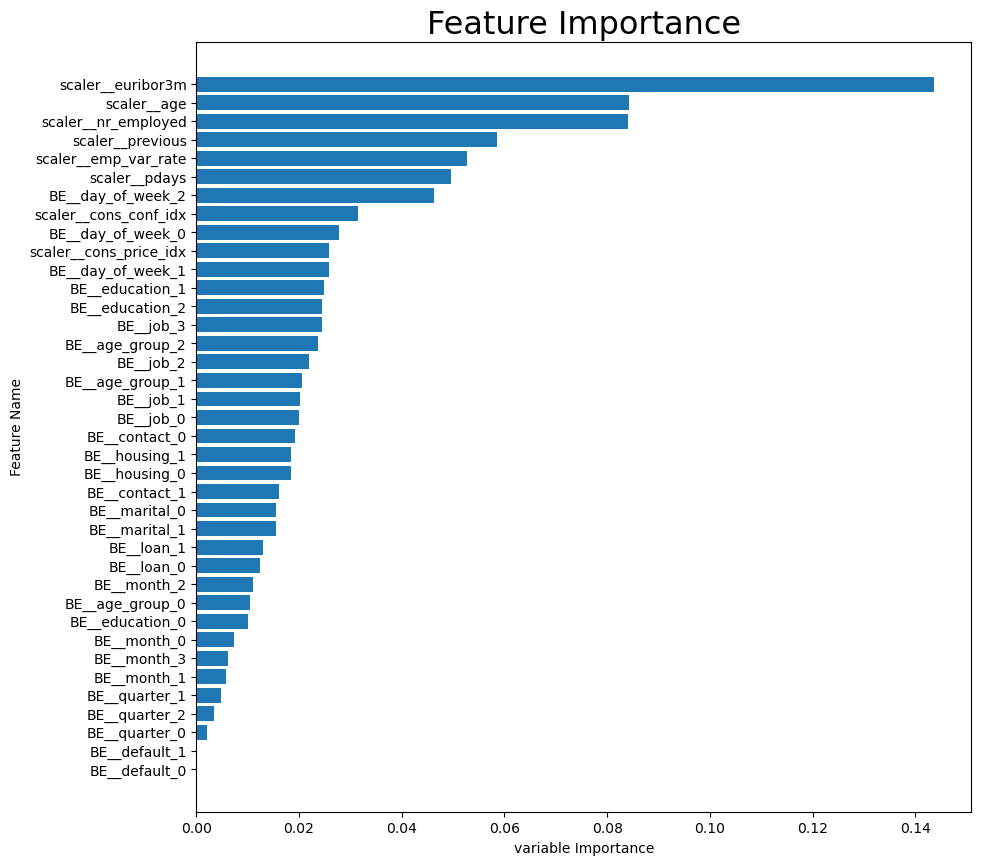

In [28]:
# bar plot to show feature importance
plt.figure(figsize=(10, 10))
plt.barh(y= sorted_column_names , width= sorted_importance)
plt.ylabel('Feature Name')
plt.xlabel('variable Importance')
plt.title('Feature Importance', fontsize=23)
plt.show()

- __Note1:__ euribor3m is the most important feature in data
- __Note2:__ Although default and quarter columns is an unimportant so i will drop it 

In [29]:
# drop column 
x_train.drop(['default' , 'quarter'],axis = 1 ,inplace=True)
col_enco = x_train.select_dtypes(include="O").columns.to_list()
col_enco

['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'age_group']

In [30]:
preprocessor = ColumnTransformer(transformers=
                            [('BE', BinaryEncoder(), col_enco),
                            ('scaler' , MinMaxScaler(),col_to_scal)],
                            remainder='passthrough')

<a id=section7></a>
# Hyper Parameter Tuning

**In this process i will do fro :**

1) [**Random Forest Classifier**](#section11)</br>
2) [**XGBClassifier**](#section12)</br>

<a id=section11></a>
## Random Forest Classifier Model

In [31]:
# intailization Model 
steps = []
steps.append(('preprocessor', preprocessor))
steps.append(('smoT', SMOTETomek()))
steps.append(('RF', RandomForestClassifier()))

pipeline = Pipeline(steps=steps)

result_rf = cross_validate(pipeline , X =x_train,y= y_train, cv=5, scoring='f1',
                        return_train_score=True)

In [32]:
print(f" intailization RF Train score is {result_rf['train_score'].mean()}")
print(f" intailization RF Test score is {result_rf['test_score'].mean()}")

 intailization RF Train score is 0.9003251442008148
 intailization RF Test score is 0.41867619597436045


In [33]:
pipeline[-1]

RandomForestClassifier()

In [47]:
parmas = {
    'RF__n_estimators' : [50,100, 150],
    'RF__criterion' : ['gini', 'entropy', 'log_loss'],
    'RF__max_depth': [None, 10, 20],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],
    'RF__max_features': ['log2', 'sqrt'],
    'RF__bootstrap': [True, False]
}

In [48]:
grid = GridSearchCV(estimator=pipeline ,param_grid=parmas,cv=5,verbose=3,scoring='f1',return_train_score=True,error_score='raise' )


In [49]:
# fit grid search with hyperparameter 
grid.fit(x_train,y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.894, test=0.411) total time=   5.2s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.901, test=0.434) total time=   4.9s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.897, test=0.404) total time=   5.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.905, test=0.431) total time=   4.9s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_dep

[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.732, test=0.482) total time=   7.9s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.733, test=0.458) total time=   7.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.727, test=0.457) total time=  10.7s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.731, test=0.453) total time=  10.9s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, 

[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.701, test=0.473) total time=   4.9s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.696, test=0.454) total time=   4.6s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.699, test=0.469) total time=   5.0s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.703, test=0.475) total time=   4.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__

[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.662, test=0.492) total time=   7.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.675, test=0.473) total time=   9.4s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.661, test=0.483) total time=   9.7s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.670, test=0.486) total time=   9.6s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__

[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.810, test=0.430) total time=   5.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.816, test=0.454) total time=   5.1s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.813, test=0.427) total time=   5.3s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.813, test=0.441) total time=   8.4s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min

[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.768, test=0.454) total time=  11.3s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.778, test=0.454) total time=  11.2s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.769, test=0.448) total time=  11.3s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.775, test=0.465) total time=  11.5s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__

[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.671, test=0.487) total time=   5.0s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.678, test=0.481) total time=   5.3s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.677, test=0.474) total time=   7.9s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.671, test=0.475) total time=   8.1s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__mi

[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.665, test=0.482) total time=  11.2s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.672, test=0.471) total time=  10.3s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.668, test=0.494) total time=  10.3s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.665, test=0.489) total time=  10.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF

[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.552, test=0.511) total time=   3.8s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.552, test=0.503) total time=   5.8s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.558, test=0.514) total time=   5.6s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.556, test=0.518) total time=   5.6s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_sam

[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.552, test=0.516) total time=   8.0s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.555, test=0.525) total time=   7.9s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.558, test=0.522) total time=   8.3s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.553, test=0.512) total time=   4.2s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_sample

[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.549, test=0.507) total time=   5.7s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.553, test=0.512) total time=   5.5s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.550, test=0.514) total time=   5.6s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.551, test=0.518) total time=   5.7s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_sample

[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.565, test=0.524) total time=   8.9s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.565, test=0.510) total time=   9.2s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.565, test=0.504) total time=   4.3s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.565, test=0.508) total time=   4.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_

[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.566, test=0.510) total time=   6.5s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.563, test=0.513) total time=   6.6s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.565, test=0.523) total time=   6.6s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.562, test=0.514) total time=   6.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_sample

[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.558, test=0.512) total time=   8.7s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.554, test=0.506) total time=   4.4s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.556, test=0.505) total time=   4.3s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.553, test=0.513) total time=   4.2s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_

[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.552, test=0.514) total time=   5.8s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.553, test=0.518) total time=   4.7s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.552, test=0.516) total time=   4.9s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.557, test=0.505) total time=   7.2s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_sa

[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.717, test=0.454) total time=   3.5s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.714, test=0.452) total time=   3.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.713, test=0.451) total time=   3.5s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.717, test=0.489) total time=   3.6s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_sample

[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.747, test=0.474) total time=   5.6s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.739, test=0.464) total time=   5.7s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.741, test=0.466) total time=   8.2s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.740, test=0.457) total time=   7.6s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_sample

[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.662, test=0.483) total time=   3.1s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.665, test=0.472) total time=   3.0s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.663, test=0.505) total time=   3.0s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.658, test=0.496) total time=   3.0s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_sp

[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.869, test=0.415) total time=   6.0s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.870, test=0.420) total time=   8.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.870, test=0.430) total time=   9.0s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.866, test=0.429) total time=   9.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_sample

[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.755, test=0.433) total time=   3.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.755, test=0.460) total time=   3.4s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.755, test=0.458) total time=   3.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.757, test=0.462) total time=   5.8s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_s

[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.701, test=0.462) total time=   7.9s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.698, test=0.459) total time=   7.9s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.699, test=0.454) total time=   8.0s
[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.697, test=0.483) total time=   8.2s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_sa

[CV 4/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.660, test=0.492) total time=   3.7s
[CV 5/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.662, test=0.482) total time=   3.7s
[CV 1/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.670, test=0.473) total time=   5.9s
[CV 2/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.664, test=0.470) total time=   5.8s
[CV 3/5] END RF__bootstrap=True, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samp

[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.817, test=0.438) total time=   8.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.816, test=0.431) total time=   8.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.820, test=0.441) total time=   8.3s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.822, test=0.438) total time=   8.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_sampl

[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.757, test=0.457) total time=   3.8s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.754, test=0.463) total time=   3.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.750, test=0.458) total time=   6.3s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.762, test=0.460) total time=   5.8s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples

[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.673, test=0.471) total time=   7.5s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.668, test=0.475) total time=   7.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.672, test=0.478) total time=   7.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.674, test=0.483) total time=   7.5s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_sampl

[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.897, test=0.394) total time=   3.8s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.902, test=0.426) total time=   3.8s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.903, test=0.387) total time=   3.8s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.895, test=0.422) total time=   6.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_

[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.732, test=0.448) total time=   6.0s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.729, test=0.453) total time=   8.7s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.732, test=0.453) total time=   8.7s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.729, test=0.447) total time=   8.7s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_s

[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.707, test=0.466) total time=   3.6s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.708, test=0.457) total time=   3.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.714, test=0.478) total time=   3.5s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.711, test=0.464) total time=   3.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_sampl

[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.680, test=0.487) total time=   5.8s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.677, test=0.484) total time=   5.7s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.682, test=0.461) total time=   8.1s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.680, test=0.472) total time=   8.1s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_sampl

[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.553, test=0.508) total time=   2.5s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.551, test=0.514) total time=   2.5s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.550, test=0.516) total time=   2.5s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.550, test=0.515) total time=   2.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF_

[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.555, test=0.518) total time=   4.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.552, test=0.508) total time=   6.3s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.556, test=0.509) total time=   6.5s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.550, test=0.515) total time=   6.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2,

[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.545, test=0.518) total time=   2.7s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.550, test=0.512) total time=   2.7s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.546, test=0.519) total time=   2.8s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.549, test=0.509) total time=   4.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF

[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.546, test=0.505) total time=   6.1s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.547, test=0.510) total time=   6.0s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.542, test=0.516) total time=   5.8s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.548, test=0.519) total time=   6.0s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_lea

[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.554, test=0.521) total time=   2.9s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.555, test=0.509) total time=   3.0s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.556, test=0.500) total time=   4.8s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.552, test=0.512) total time=   4.8s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=

[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.555, test=0.508) total time=   6.5s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.554, test=0.514) total time=   6.5s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.556, test=0.522) total time=   6.5s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.557, test=0.517) total time=   6.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2,

[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.551, test=0.511) total time=   2.9s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.547, test=0.497) total time=   4.7s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.552, test=0.512) total time=   4.7s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.552, test=0.513) total time=   4.9s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, 

[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.864, test=0.418) total time=   8.8s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.867, test=0.454) total time=   8.9s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.860, test=0.433) total time=   9.1s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.780, test=0.442) total time=   3.5s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, 

[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.750, test=0.450) total time=   5.5s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.753, test=0.454) total time=   5.6s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.745, test=0.448) total time=   5.6s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.751, test=0.475) total time=   5.5s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2,

[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.693, test=0.486) total time=   7.7s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.698, test=0.479) total time=   8.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.660, test=0.473) total time=   3.3s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.658, test=0.486) total time=   3.5s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4,

[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.658, test=0.488) total time=   5.3s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.660, test=0.476) total time=   5.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.659, test=0.493) total time=   5.1s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.659, test=0.489) total time=   5.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_lea

[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.782, test=0.441) total time=   9.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.711, test=0.450) total time=   3.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.712, test=0.454) total time=   3.5s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.714, test=0.447) total time=   3.7s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1,

[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.745, test=0.450) total time=   6.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.752, test=0.466) total time=   6.0s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.751, test=0.457) total time=   6.0s
[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.746, test=0.452) total time=   8.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2,

[CV 1/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.674, test=0.466) total time=   3.4s
[CV 2/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.673, test=0.478) total time=   3.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.680, test=0.457) total time=   3.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.677, test=0.493) total time=   3.4s
[CV 5/5] END RF__bootstrap=True, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF_

[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.901, test=0.437) total time=   6.1s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.902, test=0.408) total time=   6.0s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.898, test=0.433) total time=   8.7s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.900, test=0.424) total time=   8.9s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_

[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.762, test=0.455) total time=   3.3s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.763, test=0.465) total time=   3.3s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.761, test=0.444) total time=   3.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.763, test=0.470) total time=   3.3s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samp

[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.705, test=0.466) total time=   5.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.705, test=0.479) total time=   5.4s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.708, test=0.468) total time=   5.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.706, test=0.467) total time=   7.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__

[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.671, test=0.484) total time=   7.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.666, test=0.476) total time=   3.1s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.657, test=0.481) total time=   3.1s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.660, test=0.485) total time=   3.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_

[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.815, test=0.438) total time=   6.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.812, test=0.413) total time=   6.5s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.824, test=0.448) total time=   6.4s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.819, test=0.434) total time=   6.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_

[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.775, test=0.456) total time=   8.8s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.778, test=0.446) total time=   8.9s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.763, test=0.445) total time=   3.7s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.756, test=0.451) total time=   3.6s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_sa

[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.681, test=0.466) total time=   5.9s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.680, test=0.479) total time=   5.8s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.681, test=0.471) total time=   5.9s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.683, test=0.486) total time=   5.8s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_

[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.678, test=0.474) total time=   8.3s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.676, test=0.491) total time=   8.2s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.673, test=0.474) total time=   8.2s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.553, test=0.502) total time=   2.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_sa

[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.552, test=0.506) total time=   4.1s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.551, test=0.509) total time=   4.1s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.548, test=0.517) total time=   4.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.551, test=0.523) total time=   4.1s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_sample

[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.552, test=0.519) total time=   5.7s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.552, test=0.515) total time=   5.7s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.549, test=0.508) total time=   2.6s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.548, test=0.508) total time=   2.6s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_le

[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.546, test=0.509) total time=   4.1s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.544, test=0.513) total time=   4.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.547, test=0.520) total time=   4.1s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.550, test=0.514) total time=   4.1s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_le

[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.557, test=0.517) total time=   6.3s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.558, test=0.497) total time=   2.8s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.561, test=0.507) total time=   2.7s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.556, test=0.519) total time=   2.8s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=

[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.555, test=0.509) total time=   4.6s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.558, test=0.524) total time=   4.6s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.559, test=0.513) total time=   4.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.557, test=0.497) total time=   6.5s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_le

[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.554, test=0.498) total time=   2.8s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.548, test=0.509) total time=   2.7s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.553, test=0.516) total time=   2.8s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.548, test=0.516) total time=   2.8s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4

[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.550, test=0.514) total time=   4.5s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.551, test=0.513) total time=   4.6s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.550, test=0.500) total time=   6.4s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.553, test=0.511) total time=   6.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_sample

[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.711, test=0.469) total time=   3.2s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.718, test=0.439) total time=   3.2s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.716, test=0.487) total time=   3.1s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.716, test=0.465) total time=   3.2s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_le

[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.744, test=0.468) total time=   5.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.741, test=0.455) total time=   7.7s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.742, test=0.458) total time=   7.7s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.740, test=0.454) total time=   7.7s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_le

[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.666, test=0.489) total time=   3.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.660, test=0.497) total time=   3.1s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.660, test=0.483) total time=   3.1s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.672, test=0.481) total time=   5.2s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=

[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.863, test=0.433) total time=   9.2s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.860, test=0.443) total time=   9.1s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.862, test=0.421) total time=   9.1s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.869, test=0.452) total time=   9.2s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_le

[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.757, test=0.465) total time=   3.6s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.754, test=0.460) total time=   3.5s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.757, test=0.449) total time=   6.0s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.758, test=0.444) total time=   6.0s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf

[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.698, test=0.461) total time=   8.4s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.699, test=0.460) total time=   8.4s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.706, test=0.485) total time=   8.4s
[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.703, test=0.469) total time=   8.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_sample

[CV 5/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.665, test=0.487) total time=   3.4s
[CV 1/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.670, test=0.477) total time=   5.8s
[CV 2/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.665, test=0.474) total time=   5.8s
[CV 3/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.669, test=0.461) total time=   5.8s
[CV 4/5] END RF__bootstrap=True, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples

[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.879, test=0.407) total time=   9.6s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.884, test=0.424) total time=   9.4s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.884, test=0.400) total time=   9.4s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.804, test=0.419) total time=   3.7s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1,

[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.824, test=0.422) total time=   6.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.824, test=0.439) total time=   6.5s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.824, test=0.426) total time=   6.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.826, test=0.450) total time=   6.4s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2,

[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.735, test=0.473) total time=   8.5s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.727, test=0.469) total time=   8.4s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.724, test=0.456) total time=   3.5s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.728, test=0.472) total time=   3.5s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, R

[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.897, test=0.390) total time=   7.7s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.895, test=0.382) total time=   7.7s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.898, test=0.422) total time=   7.7s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.899, test=0.392) total time=   7.7s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1,

[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.804, test=0.436) total time=  10.0s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.841, test=0.412) total time=   4.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.842, test=0.424) total time=   4.0s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.835, test=0.405) total time=   4.1s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, R

[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.771, test=0.428) total time=   6.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.776, test=0.460) total time=   6.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.782, test=0.443) total time=   6.8s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.772, test=0.433) total time=   9.8s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_lea

[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.726, test=0.443) total time=   3.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.737, test=0.453) total time=   3.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.732, test=0.453) total time=   3.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.741, test=0.474) total time=   3.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4,

[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.563, test=0.515) total time=   4.4s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.564, test=0.512) total time=   4.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.566, test=0.504) total time=   6.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.566, test=0.512) total time=   6.3s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_s

[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.563, test=0.503) total time=   2.7s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.563, test=0.514) total time=   2.7s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.562, test=0.526) total time=   2.7s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.564, test=0.512) total time=   2.7s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_sampl

[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.555, test=0.516) total time=   4.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.553, test=0.503) total time=   6.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.560, test=0.509) total time=   6.2s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.556, test=0.518) total time=   6.2s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_s

[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.568, test=0.516) total time=   3.0s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.570, test=0.515) total time=   3.0s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.578, test=0.513) total time=   3.0s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.566, test=0.498) total time=   5.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samp

[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.560, test=0.501) total time=   7.2s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.568, test=0.512) total time=   7.0s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.562, test=0.517) total time=   7.0s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.564, test=0.521) total time=   7.1s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__m

[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.562, test=0.525) total time=   3.1s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.570, test=0.509) total time=   3.0s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.563, test=0.499) total time=   5.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.562, test=0.515) total time=   5.0s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min

[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.564, test=0.506) total time=   7.0s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.564, test=0.512) total time=   7.1s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.562, test=0.517) total time=   7.1s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.565, test=0.516) total time=   7.0s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_s

[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.839, test=0.413) total time=   3.7s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.850, test=0.408) total time=   6.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.842, test=0.416) total time=   6.4s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.838, test=0.408) total time=   6.3s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_sa

[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.807, test=0.419) total time=   8.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.814, test=0.453) total time=   8.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.809, test=0.440) total time=   8.9s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.801, test=0.432) total time=   3.8s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_sa

[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.719, test=0.450) total time=   6.0s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.725, test=0.457) total time=   6.1s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.729, test=0.450) total time=   6.0s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.723, test=0.481) total time=   5.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_s

[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.717, test=0.476) total time=   8.2s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.721, test=0.470) total time=   8.2s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.884, test=0.403) total time=   4.2s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.882, test=0.404) total time=   4.1s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_s

[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.791, test=0.446) total time=   6.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.786, test=0.431) total time=   6.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.790, test=0.456) total time=   6.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.784, test=0.441) total time=   6.8s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__m

[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.803, test=0.428) total time=   9.9s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.760, test=0.442) total time=   3.8s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.764, test=0.447) total time=   3.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.755, test=0.434) total time=   3.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_s

[CV 3/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.732, test=0.451) total time=   6.7s
[CV 4/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.738, test=0.477) total time=   6.6s
[CV 5/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.742, test=0.459) total time=   6.8s
[CV 1/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.726, test=0.455) total time=   9.4s
[CV 2/5] END RF__bootstrap=False, RF__criterion=gini, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_s

[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.877, test=0.422) total time=   4.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.876, test=0.424) total time=   4.1s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.879, test=0.395) total time=   4.1s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.881, test=0.432) total time=   4.1s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samp

[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.837, test=0.404) total time=   7.2s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.840, test=0.442) total time=   6.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.837, test=0.417) total time=   7.0s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.835, test=0.427) total time=   9.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_

[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.773, test=0.441) total time=   9.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.738, test=0.457) total time=   3.8s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.735, test=0.459) total time=   3.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.733, test=0.449) total time=   3.8s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_sa

[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.733, test=0.464) total time=   6.5s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.732, test=0.452) total time=   6.5s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.734, test=0.474) total time=   6.5s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.732, test=0.471) total time=   6.4s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=log2, RF__

[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.886, test=0.412) total time=  11.6s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.884, test=0.402) total time=  11.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.805, test=0.432) total time=   4.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.808, test=0.436) total time=   4.3s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_

[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.830, test=0.426) total time=   7.8s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.831, test=0.431) total time=   7.7s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.828, test=0.417) total time=   7.7s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.836, test=0.433) total time=   7.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_

[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.748, test=0.436) total time=  10.5s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.754, test=0.477) total time=  10.6s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.752, test=0.455) total time=  10.4s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.745, test=0.441) total time=   4.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=None, RF__max_features=sqrt, RF__min_s

[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.560, test=0.508) total time=   2.9s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.556, test=0.506) total time=   4.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.564, test=0.504) total time=   4.9s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.557, test=0.517) total time=   5.0s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_lea

[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.551, test=0.518) total time=   6.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.557, test=0.522) total time=   6.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.555, test=0.511) total time=   7.0s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.560, test=0.507) total time=   2.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_

[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.555, test=0.506) total time=   4.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.555, test=0.510) total time=   4.9s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.552, test=0.518) total time=   4.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.558, test=0.520) total time=   4.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_sample

[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.550, test=0.518) total time=   6.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.553, test=0.515) total time=   6.8s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.549, test=0.506) total time=   2.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.552, test=0.505) total time=   2.9s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=log2, RF__min_samples_le

[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.562, test=0.507) total time=   5.4s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.560, test=0.510) total time=   5.5s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.560, test=0.523) total time=   5.5s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.562, test=0.516) total time=   5.4s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_le

[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.564, test=0.515) total time=   7.7s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.562, test=0.499) total time=   3.2s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.565, test=0.507) total time=   3.2s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.557, test=0.510) total time=   3.2s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=

[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.553, test=0.512) total time=   5.5s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.555, test=0.517) total time=   5.5s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.560, test=0.515) total time=   5.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.554, test=0.502) total time=   7.8s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_le

[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.874, test=0.426) total time=   4.2s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.869, test=0.409) total time=   4.0s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.875, test=0.394) total time=   4.1s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.881, test=0.420) total time=   4.0s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1

[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.787, test=0.461) total time=   6.7s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.783, test=0.439) total time=   6.6s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.782, test=0.424) total time=   9.5s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.782, test=0.442) total time=   9.5s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_sample

[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.762, test=0.444) total time=   3.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.755, test=0.444) total time=   3.8s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.761, test=0.469) total time=   3.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.755, test=0.455) total time=   4.1s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_le

[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.724, test=0.457) total time=   6.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.725, test=0.454) total time=   9.2s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.724, test=0.454) total time=   9.1s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.730, test=0.448) total time=   9.2s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=log2, RF__min_samples_le

[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.833, test=0.406) total time=   4.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.846, test=0.435) total time=   4.3s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.839, test=0.413) total time=   4.2s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.844, test=0.422) total time=   7.7s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=

[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.812, test=0.429) total time=  10.8s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.806, test=0.437) total time=  10.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.804, test=0.420) total time=  10.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.814, test=0.456) total time=  10.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_le

[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.733, test=0.471) total time=   4.1s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.730, test=0.458) total time=   4.1s
[CV 1/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.726, test=0.445) total time=   7.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.735, test=0.458) total time=   7.3s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf

[CV 2/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.727, test=0.456) total time=  10.2s
[CV 3/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.725, test=0.439) total time=  10.2s
[CV 4/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.741, test=0.477) total time=  10.2s
[CV 5/5] END RF__bootstrap=False, RF__criterion=entropy, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.727, test=0.446) total time=  10.4s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_sam

[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.812, test=0.446) total time=   3.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.809, test=0.418) total time=   3.9s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.803, test=0.428) total time=   7.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.808, test=0.438) total time=   6.9s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, R

[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.827, test=0.426) total time=   9.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.827, test=0.440) total time=   9.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.824, test=0.427) total time=   9.8s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.829, test=0.451) total time=  10.4s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF_

[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.737, test=0.460) total time=   5.6s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.738, test=0.465) total time=   5.4s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.736, test=0.464) total time=   5.6s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.738, test=0.448) total time=   9.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=log2, RF__mi

[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.898, test=0.386) total time=  11.7s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.891, test=0.391) total time=  16.1s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.895, test=0.399) total time=  16.2s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.896, test=0.400) total time=  16.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF_

[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.839, test=0.430) total time=   6.5s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.838, test=0.421) total time=   6.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.843, test=0.444) total time=   7.2s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.838, test=0.410) total time=   6.6s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min

[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.782, test=0.456) total time=  11.2s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.782, test=0.429) total time=  11.6s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.774, test=0.433) total time=  16.4s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.782, test=0.444) total time=  15.5s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt,

[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.736, test=0.446) total time=   6.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.737, test=0.447) total time=   6.2s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.734, test=0.432) total time=   7.0s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.736, test=0.469) total time=   6.9s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=None, RF__max_features=sqrt, RF_

[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.556, test=0.517) total time=   7.7s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.558, test=0.517) total time=   8.2s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.559, test=0.514) total time=   8.0s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.558, test=0.503) total time=   9.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_sampl

[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.558, test=0.508) total time=  11.2s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.555, test=0.504) total time=   4.7s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.560, test=0.508) total time=   4.9s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.554, test=0.515) total time=   5.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_

[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.549, test=0.510) total time=   7.7s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.547, test=0.518) total time=   7.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.553, test=0.521) total time=   7.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.552, test=0.513) total time=   8.1s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_sampl

[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.553, test=0.519) total time=  10.4s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.553, test=0.510) total time=  10.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.560, test=0.503) total time=   5.3s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.565, test=0.511) total time=   5.2s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_sampl

[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.558, test=0.499) total time=   6.0s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.561, test=0.505) total time=   6.3s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.558, test=0.511) total time=   6.1s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.559, test=0.519) total time=   6.0s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_s

[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.559, test=0.513) total time=   8.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.560, test=0.515) total time=   8.3s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.566, test=0.517) total time=   7.9s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.558, test=0.498) total time=   3.5s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_sampl

[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.556, test=0.512) total time=   3.4s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.555, test=0.502) total time=   5.7s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.553, test=0.514) total time=   5.9s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.560, test=0.518) total time=   5.9s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=10, RF__max_features=sqrt, RF__min_sample

[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.872, test=0.417) total time=  11.2s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.877, test=0.401) total time=  11.1s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.881, test=0.425) total time=  10.7s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=1, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.879, test=0.409) total time=  10.7s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_sampl

[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.809, test=0.456) total time=   4.0s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=50;, score=(train=0.799, test=0.422) total time=   3.9s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.805, test=0.438) total time=   6.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.804, test=0.444) total time=   7.0s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples

[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.754, test=0.439) total time=   9.6s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.760, test=0.446) total time=   9.6s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.757, test=0.434) total time=   9.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=150;, score=(train=0.761, test=0.473) total time=   9.5s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_s

[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.716, test=0.454) total time=   4.2s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.722, test=0.471) total time=   3.8s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=50;, score=(train=0.715, test=0.468) total time=   3.9s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samples_leaf=4, RF__min_samples_split=10, RF__n_estimators=100;, score=(train=0.716, test=0.459) total time=   6.7s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=log2, RF__min_samp

[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=100;, score=(train=0.843, test=0.424) total time=   7.5s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.842, test=0.417) total time=  10.9s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.835, test=0.434) total time=  10.8s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=1, RF__min_samples_split=5, RF__n_estimators=150;, score=(train=0.840, test=0.402) total time=  11.4s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_sampl

[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.803, test=0.435) total time=   4.3s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.801, test=0.422) total time=   4.2s
[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.808, test=0.451) total time=   4.3s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=5, RF__n_estimators=50;, score=(train=0.805, test=0.435) total time=   4.2s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_l

[CV 4/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.739, test=0.469) total time=   7.7s
[CV 5/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=100;, score=(train=0.737, test=0.462) total time=   7.7s
[CV 1/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.727, test=0.449) total time=  10.7s
[CV 2/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_samples_leaf=4, RF__min_samples_split=2, RF__n_estimators=150;, score=(train=0.736, test=0.451) total time=  11.4s
[CV 3/5] END RF__bootstrap=False, RF__criterion=log_loss, RF__max_depth=20, RF__max_features=sqrt, RF__min_sampl

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('BE',
                                                                         BinaryEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'quarter',
                                                                          'age_group']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp_var_rate',
                                                                          'cons_price_id...
                                       ('smoT', SMOTETomek()),
                                       ('RF', RandomForestClassifier())]),
             param_grid={'RF__bootstrap': [True, False],
                         'RF__criterion': ['gini', 'entropy', 'log_loss'],
                         'RF__max_depth': [None, 10, 20],
                         'RF__max_features': ['log2', 'sqrt'],
                         'RF__min_samples_leaf': [1, 2, 4],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='f1', verbose=3)

In [50]:
# get best parameters
grid.best_params_

{'RF__bootstrap': False,
 'RF__criterion': 'entropy',
 'RF__max_depth': 10,
 'RF__max_features': 'log2',
 'RF__min_samples_leaf': 4,
 'RF__min_samples_split': 5,
 'RF__n_estimators': 50}

In [51]:
# max train score 
grid.cv_results_["mean_train_score"].max()

0.9014708698756564

In [52]:
# max test score 
grid.cv_results_["mean_test_score"].max()

0.5156321590771331

<a id=section12></a>
## XGBClassifier

In [34]:
# second Model 
steps = []
steps.append(('preprocessor', preprocessor))
steps.append(('smoT', SMOTETomek()))
steps.append(('XGBC', XGBClassifier()))

pipeline = Pipeline(steps=steps)

result_xg = cross_validate(pipeline , X =x_train,y= y_train, cv=5, scoring='f1',
                        return_train_score=True)

In [35]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('BE', BinaryEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact', 'month',
                                                   'day_of_week',
                                                   'age_group']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['age', 'pdays', 'previous',
                                                   'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed'])])),
                ('smoT', SMOTETomek...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [36]:
print(f" xgb Train score is {result_xg['train_score'].mean()}")
print(f" xgb Test score is {result_xg['test_score'].mean()}")

 xgb Train score is 0.6207324949383184
 xgb Test score is 0.4002929014194018


In [37]:
parameters = {

    
    'XGBC__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'XGBC__subsample':[i/10.0 for i in range(6,10)],
    'XGBC__colsample_bytree':[i/10.0 for i in range(6,10)],
    'XGBC__gamma':[i/10.0 for i in range(0,5)],
    'XGBC__max_depth': range(3,10,2) ,
    'XGBC__min_child_weight' : range(1,6,2)

             }


In [68]:
# here i will use random search
grid2 = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters ,
                          cv = 5,verbose=3,return_train_score=True)

In [69]:
# fit data
grid2.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END XGBC__colsample_bytree=0.7, XGBC__gamma=0.0, XGBC__max_depth=5, XGBC__min_child_weight=5, XGBC__reg_alpha=0.01, XGBC__subsample=0.6;, score=(train=0.908, test=0.883) total time=   1.7s
[CV 2/5] END XGBC__colsample_bytree=0.7, XGBC__gamma=0.0, XGBC__max_depth=5, XGBC__min_child_weight=5, XGBC__reg_alpha=0.01, XGBC__subsample=0.6;, score=(train=0.907, test=0.882) total time=   1.7s
[CV 3/5] END XGBC__colsample_bytree=0.7, XGBC__gamma=0.0, XGBC__max_depth=5, XGBC__min_child_weight=5, XGBC__reg_alpha=0.01, XGBC__subsample=0.6;, score=(train=0.906, test=0.876) total time=   1.8s
[CV 4/5] END XGBC__colsample_bytree=0.7, XGBC__gamma=0.0, XGBC__max_depth=5, XGBC__min_child_weight=5, XGBC__reg_alpha=0.01, XGBC__subsample=0.6;, score=(train=0.906, test=0.881) total time=   1.7s
[CV 5/5] END XGBC__colsample_bytree=0.7, XGBC__gamma=0.0, XGBC__max_depth=5, XGBC__min_child_weight=5, XGBC__reg_alpha=0.01, XGBC__subsample=0.6;, 

[CV 3/5] END XGBC__colsample_bytree=0.8, XGBC__gamma=0.1, XGBC__max_depth=5, XGBC__min_child_weight=3, XGBC__reg_alpha=100, XGBC__subsample=0.7;, score=(train=0.875, test=0.877) total time=   1.7s
[CV 4/5] END XGBC__colsample_bytree=0.8, XGBC__gamma=0.1, XGBC__max_depth=5, XGBC__min_child_weight=3, XGBC__reg_alpha=100, XGBC__subsample=0.7;, score=(train=0.877, test=0.870) total time=   1.8s
[CV 5/5] END XGBC__colsample_bytree=0.8, XGBC__gamma=0.1, XGBC__max_depth=5, XGBC__min_child_weight=3, XGBC__reg_alpha=100, XGBC__subsample=0.7;, score=(train=0.875, test=0.873) total time=   2.1s
[CV 1/5] END XGBC__colsample_bytree=0.8, XGBC__gamma=0.2, XGBC__max_depth=7, XGBC__min_child_weight=3, XGBC__reg_alpha=0.01, XGBC__subsample=0.8;, score=(train=0.930, test=0.879) total time=   2.2s
[CV 2/5] END XGBC__colsample_bytree=0.8, XGBC__gamma=0.2, XGBC__max_depth=7, XGBC__min_child_weight=3, XGBC__reg_alpha=0.01, XGBC__subsample=0.8;, score=(train=0.931, test=0.877) total time=   2.5s
[CV 3/5] END 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('BE',
                                                                               BinaryEncoder(),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'day_of_week',
                                                                                'age_group']),
                                                                              ('scaler',
                                                                               MinMaxScaler(),
                                                                               ['age',
                                                                                'pdays',
                                                                                'previous',
                                                                                'emp_var_rate',
                                                                                'cons_price_idx',
                                                                                'cons_conf_idx',
                                                                                'euribor3m',
                                                                                'nr...
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=None, ...))]),
                   param_distributions={'XGBC__colsample_bytree': [0.6, 0.7,
                                                                   0.8, 0.9],
                                        'XGBC__gamma': [0.0, 0.1, 0.2, 0.3,
                                                        0.4],
                                        'XGBC__max_depth': range(3, 10, 2),
                                        'XGBC__min_child_weight': range(1, 6, 2),
                                        'XGBC__reg_alpha': [1e-05, 0.01, 0.1, 1,
                                                            100],
                                        'XGBC__subsample': [0.6, 0.7, 0.8,
                                                            0.9]},
                   return_train_score=True, verbose=3)

In [70]:
# get best parameters
grid2.best_params_

{'XGBC__subsample': 0.7,
 'XGBC__reg_alpha': 1,
 'XGBC__min_child_weight': 1,
 'XGBC__max_depth': 3,
 'XGBC__gamma': 0.1,
 'XGBC__colsample_bytree': 0.9}

In [71]:
# max train score 
grid2.cv_results_["mean_train_score"].max()

0.947834399664484

In [72]:
# max test score 
grid2.cv_results_["mean_test_score"].max()

0.8854476498087921

**After tuning for XGBC and RF i will seleect XGBC**

<a id=section8></a>
# Model Selection 

In [38]:
# pipeline
steps = []
steps.append(('preprocessor', preprocessor))
steps.append(('smoT', SMOTETomek()))
steps.append(('XGBC', XGBClassifier(subsample = 0.7 , reg_alpha =1,
                     min_child_weight = 1 , max_depth = 3 ,
                     gamma = 0.1 , colsample_bytree = 0.,
                     n_estimators=100)))

pipeline = Pipeline(steps=steps)

In [39]:
# pipeline
pipeline.fit(x_train , y_train )

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('BE', BinaryEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact', 'month',
                                                   'day_of_week',
                                                   'age_group']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['age', 'pdays', 'previous',
                                                   'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed'])])),
                ('smoT', SMOTETomek...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

<a id=section9></a>
# Classification Metrics

In [40]:
# Classification Metrics
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5315
           1       0.50      0.49      0.49       764

    accuracy                           0.87      6079
   macro avg       0.71      0.71      0.71      6079
weighted avg       0.87      0.87      0.87      6079



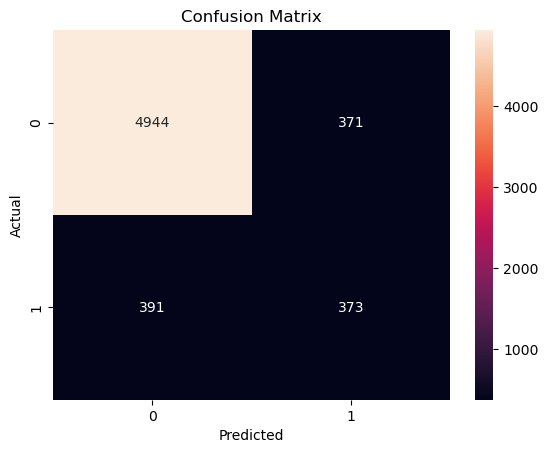

In [41]:
# heatmap for show Classification Metrics
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot= True,fmt='0.0f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# precision ,recall and threshold
from sklearn.metrics import precision_recall_curve


y_train_prob=pipeline.predict_proba(x_train)
y_test_prob=pipeline.predict_proba(x_test)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_prob[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_prob[:,1])

In [43]:
# shape for precision & recall & thresholds
print(f"shape of precision train = {precision_train.shape}")
print(f"shape of recall train = {recall_train.shape}")
print(f"shape of thresholds train = {thresholds_train.shape}")

print('-'*50)

print(f"shape of precision test = {precision_test.shape}")
print(f"shape of recall test = {recall_test.shape}")
print(f"shape of thresholds test = {thresholds_test.shape}")

shape of precision train = (14615,)
shape of recall train = (14615,)
shape of thresholds train = (14614,)
--------------------------------------------------
shape of precision test = (4891,)
shape of recall test = (4891,)
shape of thresholds test = (4890,)


In [44]:
# create data fram for Precision recall train
df_precision_recall_train= pd.DataFrame({'Threshold': thresholds_train,
                                  'Precision': precision_train[:-1],
                                  'Recall': recall_train[:-1]})
df_precision_recall_train.head()

Threshold  Precision  Recall
0   0.030336   0.125617     1.0
1   0.030686   0.125622     1.0
2   0.031130   0.125627     1.0
3   0.036115   0.125632     1.0
4   0.036751   0.125638     1.0

In [45]:
# line plot to explain Precision recall curve for train
px.line(df_precision_recall_train, x='Recall', y='Precision',hover_data = ['Threshold'], title='Precision recall curve for train ')

In [46]:
# create data fram for Precision recall test
df_precision_recall_test=pd.DataFrame({"precision":precision_test[:-1],
                           "recall":recall_test[:-1],
                            "thresholds":thresholds_test})
df_precision_recall_test.head()

precision  recall  thresholds
0   0.125679     1.0    0.030212
1   0.125699     1.0    0.034426
2   0.125720     1.0    0.035073
3   0.125741     1.0    0.036280
4   0.125761     1.0    0.037556

In [47]:
# line plot to explain Precision recall curve for test
px.line(df_precision_recall_test, x='recall', y='precision',hover_data = ['thresholds'], title='Precision recall curve for test ')

**threshold = 0.13 to get recall = 84**

<a id=section10></a>
# Save Model

In [48]:
# save model 
import pickle
pickle.dump(pipeline,open("model.pkl","wb"))

<a id=section14></a>
# Improve recall

In [52]:
# call model 
model = pickle.load(open('model.pkl', 'rb'))

In [53]:
# thresholed fuction 
def thresholed(y_prob):
    if y_prob >= 0.13 :
        return 1  
    else :
        return 0 

In [54]:
# save prediction in array
v_da = np.vectorize(thresholed)
y_train_thresh2 = v_da(model.predict_proba(x_train)[:,1])
y_test_thresh2 = v_da(model.predict_proba(x_test)[:,1])

In [55]:
y_train_thresh2

array([1, 1, 0, ..., 0, 0, 0])

In [56]:
y_test_thresh2

array([0, 1, 1, ..., 1, 0, 1])

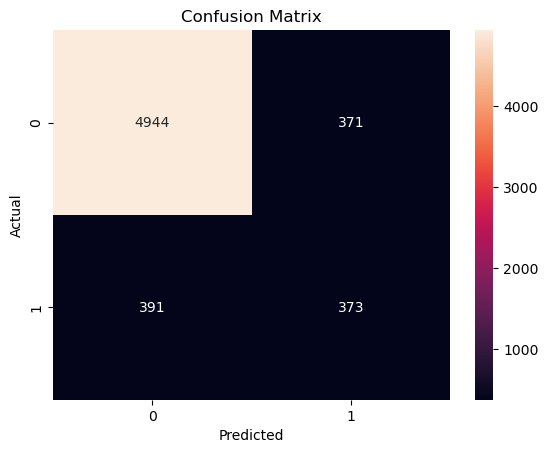

In [58]:
# # confusion matrix before modify threshold
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot= True,fmt='0.0f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


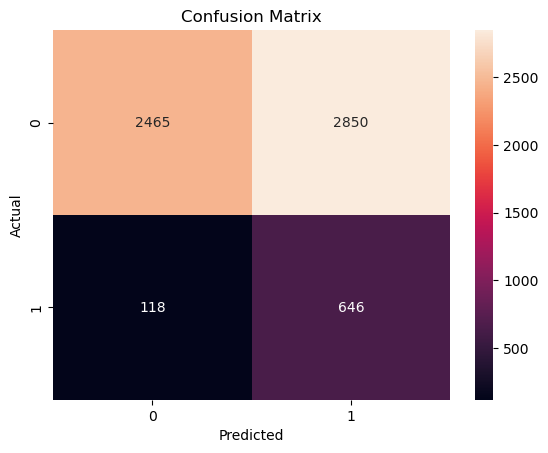

In [59]:
# confusion matrix after modify threshold
cm = confusion_matrix(y_test, y_test_thresh2)

sns.heatmap(cm, annot= True,fmt='0.0f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**After choose suitable threshold , number of FN decrease**

<a id=section13></a>
# Test Model 

In [60]:
# call model 
model = pickle.load(open('model.pkl', 'rb'))

In [61]:
# create data 
t_data={'age':  36,
 'job':  'admin.',
 'marital': 'married',
 'education':  'Basic education',
 'housing':  'no',
 'loan':  'no',
 'contact':  'telephone',
 'month':  'jun',
 'day_of_week':  'wed',
 'pdays':  0,
 'previous':  0,
 'emp_var_rate':  1.4,
 'cons_price_idx':  94.465,
 'cons_conf_idx':  -41.8,
 'euribor3m':  4.864,
 'nr_employed':  5228.1,
 'age_group':  '30-39'}

In [62]:
# save data in foramt dataframe
d1 = pd.DataFrame(t_data , index=[0] )
d1

age     job  marital        education housing loan    contact month  \
0   36  admin.  married  Basic education      no   no  telephone   jun   

  day_of_week  pdays  previous  emp_var_rate  cons_price_idx  cons_conf_idx  \
0         wed      0         0           1.4          94.465          -41.8   

   euribor3m  nr_employed age_group  
0      4.864       5228.1     30-39

In [67]:
# model predicet and choose class 1 pred
model.predict_proba(d1)[0][1]

0.091476835

In [68]:
# function to predection with modify threshold
def pred(data):
    x= model.predict_proba(data)[0][1]
    if x >= 0.13 :
        print('This client will subscribed to a term deposit') 
    else :
        print('This client will not subscribed to a term deposit')
        

In [69]:
# prediction 
pred(d1)

This client will not subscribed to a term deposit
